# 46. Функция Ламберта

## 1. Введение

Функцией Ламберта называется неинъективная функция $W(x)$, которая определяется равенством $$x=W(x) e ^ {W(x)}$$

При действительном аргументе функция $W(x)$ определена на промежутке $ x \in [-\frac{1}{e};+\infin)$. График этой функции условно можно разделить на две ветви: ветвь 0, удовлетворяющую условию $y \ge -1$; и ветвь -1, удовлетворяющую обратному условию $y < -1$. Изобразим график, используя функцию `scipy.special.lambertw()`:

In [198]:
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.special as spec
import numpy as np
import time
from warnings import simplefilter

In [199]:
%matplotlib inline
simplefilter('ignore')

In [200]:
def draw_by_builtin():
    xs = np.linspace(-0.5, 3, 10000)
    ys = np.array([spec.lambertw(x) if -np.exp(-1) <= x else None for x in xs])
    plt.plot(xs, ys, color='black')
    ys = np.array([spec.lambertw(x, k=-1) if -np.exp(-1) <= x < 0 else None for x in xs])
    plt.plot(xs, ys, color='black')


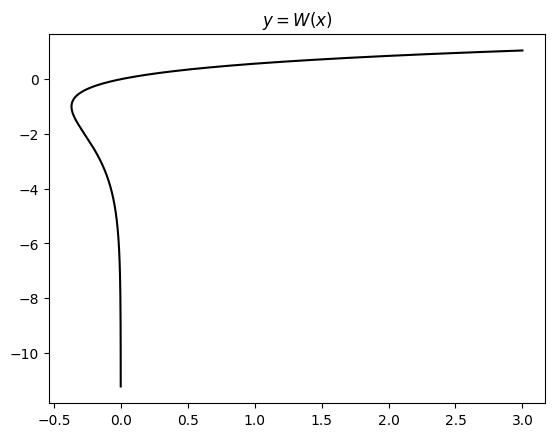

In [201]:
draw_by_builtin()
plt.title('$y = W(x)$')
plt.show()

## 2. Реализация собственного аналога для вычисления $W(x)$

### 2.1 $W_{-1}(x)$

Для начала создадим функцию, которая будет вычислять $W_{-1}(x)$ - значение функции Ламберта на ветви -1. Для этого воспользуемся функцией `scipy.optimize.newton()`, которая в отличие от `scipty.optimize.brentq()` не требует конкретного отрезка, на концах которого функция принимает значения, различающиеся знаком. Также заметим: для того, чтобы получить значение именно "нижней" ветви, переместим центр координат на единицу вверх, чтобы корень из "верхней" ветви был вне рассмотрения функции, а после вычисления вычтем прибавленную единицу, чтобы получить корректный результат. Заметим: мы манипулируем именно единицей в силу равенства $W(-\frac{1}{e}) = -1$. Таким образом:

In [202]:
def LambertW_1(x, tol=1e-10):
    def f(x,y):
        return (x-1) * np.exp(x-1) - y
    return opt.newton(f, -1.543, args=[x], tol=tol, maxiter=100) - 1

In [203]:
LambertW_1(-np.exp(-1)), LambertW_1(-np.exp(-1) + 1e-6)

(-1.0000000078804607, -1.0023334581084349)

### 2.2 $W_0(x)$

Чтобы реализовать функцию $W_0(x)$, воспользуемся еще одним разбиением: при $x \in [-\frac{1}{e}; 0]$ будем использовать `scipy.optimize.newton()`; а при $x > 0$ будем использовать `scipy.optimize.brentq()`. Для этого нам потребуется отрезок, внутри которого содержится искомое значение функции. Заметим, что для достаточно больших положительных $x$ верно неравенство $ln(x) \ge W_0(x)$, а для $x \in [-e^{-1}; e]$ определим правой границей сам $x$. Таким образом:

In [204]:
def LambertW0(x, tol=1e-8):
    lb = -np.exp(-1)
    rb = x if x <= np.e else np.log(x)

    def f(x, y):
        return x * np.exp(x) - y
    
    if x < 0: 
        return opt.newton(f, -0.35, args=[x])
    
    return opt.brentq(f, lb, rb, xtol=tol, args=[x])

In [205]:
LambertW0(-np.exp(-1)), LambertW0(-np.exp(-1) + 1e-6), LambertW0(0), LambertW0(15)

(-0.9999999845835569, -0.997670166272039, 0.0, 2.009943559350384)

### 2.3 $W(x)$

Теперь объеденим две написанные функции в одну селекторную:

In [206]:
def myLambertW(x, k=0, tol=1e-8):
    if x < -np.exp(-1): return None
    if k == -1:
        return LambertW_1(x, tol=tol)
    else: 
        return LambertW0(x, tol=tol)

## 3. Тестирование

### 3.1 Временные затраты

Создадим функцию, которая будет выводить временные результаты работы функций над заданным списком значений в табличном виде:

In [207]:
def analize_time(k,values):
    output_template = "%-25s |  %-25s %-10s | %-25s %-10s | %-10s %-10s"
    print(output_template % ('x', f'lambertw(x,{k})', 'Время (нс)', f'myLambertW(x, {k})', 'Время (нс)', 'Разность', '%'))
    print('=' * 137)
    for x in values:
        if k == -1 and x >= 0: continue
        t1 = time.perf_counter_ns()
        w1 = spec.lambertw(x, k)
        t1 = time.perf_counter_ns() - t1

        t2 = time.perf_counter_ns()
        w2 = myLambertW(x, k, tol=1e-8)
        t2 = time.perf_counter_ns() - t2
        print(output_template % (x, w1.real, t1, w2, t2, t2-t1, t1/t2 * 100))
        
    print('\n')

Протестируем функцию на некоторых значениях

In [208]:
st = -np.exp(-1)
values = [st, st+1e-6, st+1e-5, st+1e-4, st+1e-3, st+1e-2, st+1e-1, st+1, 0, 0.1, 0.2, 3, 15, 1e2, 1e4, 1e10]

Таблица для "верхней" ветви:

In [209]:
analize_time(0, values)

x                         |  lambertw(x,0)             Время (нс) | myLambertW(x, 0)          Время (нс) | Разность   %         
-0.36787944117144233      |  nan                       60000      | -0.9999999845835569       2806100    | 2746100    2.1381989237732086
-0.36787844117144236      |  -0.9976701662721043       32900      | -0.997670166272039        971500     | 938600     3.386515697375193
-0.3678694411714423       |  -0.9926447551971053       41500      | -0.9926447551964047       1031800    | 990300     4.022097305679395
-0.36777944117144235      |  -0.9768628655744274       20200      | -0.9768628655744109       807900     | 787700     2.500309444238148
-0.36687944117144233      |  -0.9280201500545666       27300      | -0.9280201500545657       619600     | 592300     4.4060684312459655
-0.3578794411714423       |  -0.7832291989812975       22000      | -0.7832291989812971       433300     | 411300     5.077313639510732
-0.26787944117144236      |  -0.39938245253978094    

Таблица для "нижней" ветви:

In [210]:
analize_time(-1, values)

x                         |  lambertw(x,-1)            Время (нс) | myLambertW(x, -1)         Время (нс) | Разность   %         
-0.36787944117144233      |  nan                       50300      | -1.0000000078804607       2218900    | 2168600    2.2668889990535854
-0.36787844117144236      |  -1.0023334581084755       27700      | -1.0023334581088885       938200     | 910500     2.952462161586016
-0.3678694411714423       |  -1.0073914890313          18600      | -1.0073914890313362       604600     | 586000     3.0764141581210716
-0.36777944117144235      |  -1.023499619082083        15700      | -1.0234996190820769       497500     | 481800     3.1557788944723617
-0.36687944117144233      |  -1.075608941186623        10900      | -1.0756089411866239       408700     | 397800     2.666992904330805
-0.3578794411714423       |  -1.2534937913672146       12000      | -1.2534937913672148       279600     | 267600     4.291845493562231
-0.26787944117144236      |  -2.0206252287754034    

* В графе "%" указано соотношение времени вычисления функции `scipy.special.lambertw()` и `myLambertW()`

### 3.2 Точность вычислений

Аналогично предыдущему пункту, создадим функцию для наглядного представления точности результатов работы функций:

In [211]:
def analyze_accuracy(k, values):
    output_template = "%-20s |  %-20s %-20s %-23s | %-20s %-20s %-23s"
    def f(x): return x * np.exp(x)
    print(output_template % ('x', f'lambertw(x, {k})', 'Обратное', 'Разность', f'myLambertW(x, {k})', 'Обратное', 'Разность'))
    print('=' * 157)
    for x in values:
        if k == -1 and x >= 0: continue
        w1 = spec.lambertw(x, k)
        w2 = myLambertW(x, k)
        x1 = f(w1.real)
        x2 = f(w2)
        print(output_template % (x, w1.real, x1, x-x1, w2, x2, x-x2))

Характеристики для "верхней" ветви:

In [212]:
analyze_accuracy(0, values)

x                    |  lambertw(x, 0)       Обратное             Разность                | myLambertW(x, 0)     Обратное             Разность               
-0.36787944117144233 |  nan                  nan                  nan                     | -0.9999999845835569  -0.3678794411714423  -5.551115123125783e-17 
-0.36787844117144236 |  -0.9976701662721043  -0.3678784411714424  5.551115123125783e-17   | -0.997670166272039   -0.3678784411714423  -5.551115123125783e-17 
-0.3678694411714423  |  -0.9926447551971053  -0.36786944117144227 -5.551115123125783e-17  | -0.9926447551964047  -0.3678694411714404  -1.942890293094024e-15 
-0.36777944117144235 |  -0.9768628655744274  -0.36777944117144235 0.0                     | -0.9768628655744109  -0.36777944117144223 -1.1102230246251565e-16
-0.36687944117144233 |  -0.9280201500545666  -0.3668794411714423  -5.551115123125783e-17  | -0.9280201500545657  -0.3668794411714423  -5.551115123125783e-17 
-0.3578794411714423  |  -0.7832291989812975  -0.3578

И для "нижней":

In [213]:
analyze_accuracy(-1, values)

x                    |  lambertw(x, -1)      Обратное             Разность                | myLambertW(x, -1)    Обратное             Разность               
-0.36787944117144233 |  nan                  nan                  nan                     | -1.0000000078804607  -0.36787944117144233 0.0                    
-0.36787844117144236 |  -1.0023334581084755  -0.3678784411714423  -5.551115123125783e-17  | -1.0023334581088885  -0.36787844117144197 -3.885780586188048e-16 
-0.3678694411714423  |  -1.0073914890313     -0.3678694411714424  5.551115123125783e-17   | -1.0073914890313362  -0.36786944117144227 -5.551115123125783e-17 
-0.36777944117144235 |  -1.023499619082083   -0.3677794411714423  -5.551115123125783e-17  | -1.0234996190820769  -0.36777944117144235 0.0                    
-0.36687944117144233 |  -1.075608941186623   -0.3668794411714424  5.551115123125783e-17   | -1.0756089411866239  -0.36687944117144233 0.0                    
-0.3578794411714423  |  -1.2534937913672146  -0.3578

## 4. Вывод

Как мы можем заметить, самописная функция на основе `scipy.optimize.newton()` и `scipy.optimize.brentq()` оказалась гораздо медленее (примерно в 30-50 раз при отрицательных $x$ и в 10-20 при положительных), чем функция `scipy.special.lambertw()`. Конечно же, это связано с тем, что используя наш способ вычисления производится огромное количество ресурснозатратных вычислений, которые вовсе необязательны для получения значения, но необходимы в контексте требуемой реализации. Для оптимизации времененных затрат, вероятно, можно было бы использовать математически выведенные формулы: например, известно, что $$W_{-1}(x)=ln\frac{-x}{-ln\frac{-x}{...}}$$ 

Кроме того, явное отличие в том, что в точке $x_0=-e^{-1}$ функция `scipy.special.lambertw()` возвращает NaN, а наша функция - достаточно близкое к истинному значение при заданной точности.

Также заметим, что обратные вычисления показывают, что функция `scipy.special.lambertw()` точнее вычисляет значения $W_1(x)$, наша же функция лучше справляется с ветвью $W_{-1}(x)$

В заключение скажем, что самописная функция действительно может быть полезна в определенных, узкоспециализированных обстоятельствах. Но в падавляющем большинстве случаев, достаточно и готовой функции `scipy.special.lambertw()`, которая в целом точнее и определенно быстрее, чем `myLambertW()`.  